In [1]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

from ban_carbon_research.config import RAW_DATA_DIR, PROCESSED_DATA_DIR

geo_pps = geopandas.read_file(PROCESSED_DATA_DIR / "Power_Plants")
rggi_pps = pd.read_csv(PROCESSED_DATA_DIR / "rggi-emissions-annual-facility.csv")
world = geopandas.read_file(PROCESSED_DATA_DIR / "geoBoundariesCGAZ_ADM0")
world.geometry = world.simplify(tolerance = 0.2)

2025-09-25 09:47:03.970 | INFO     | ban_carbon_research.config:<module>:11 - PROJ_ROOT path is: /home/fdvom/ban-carbon-research


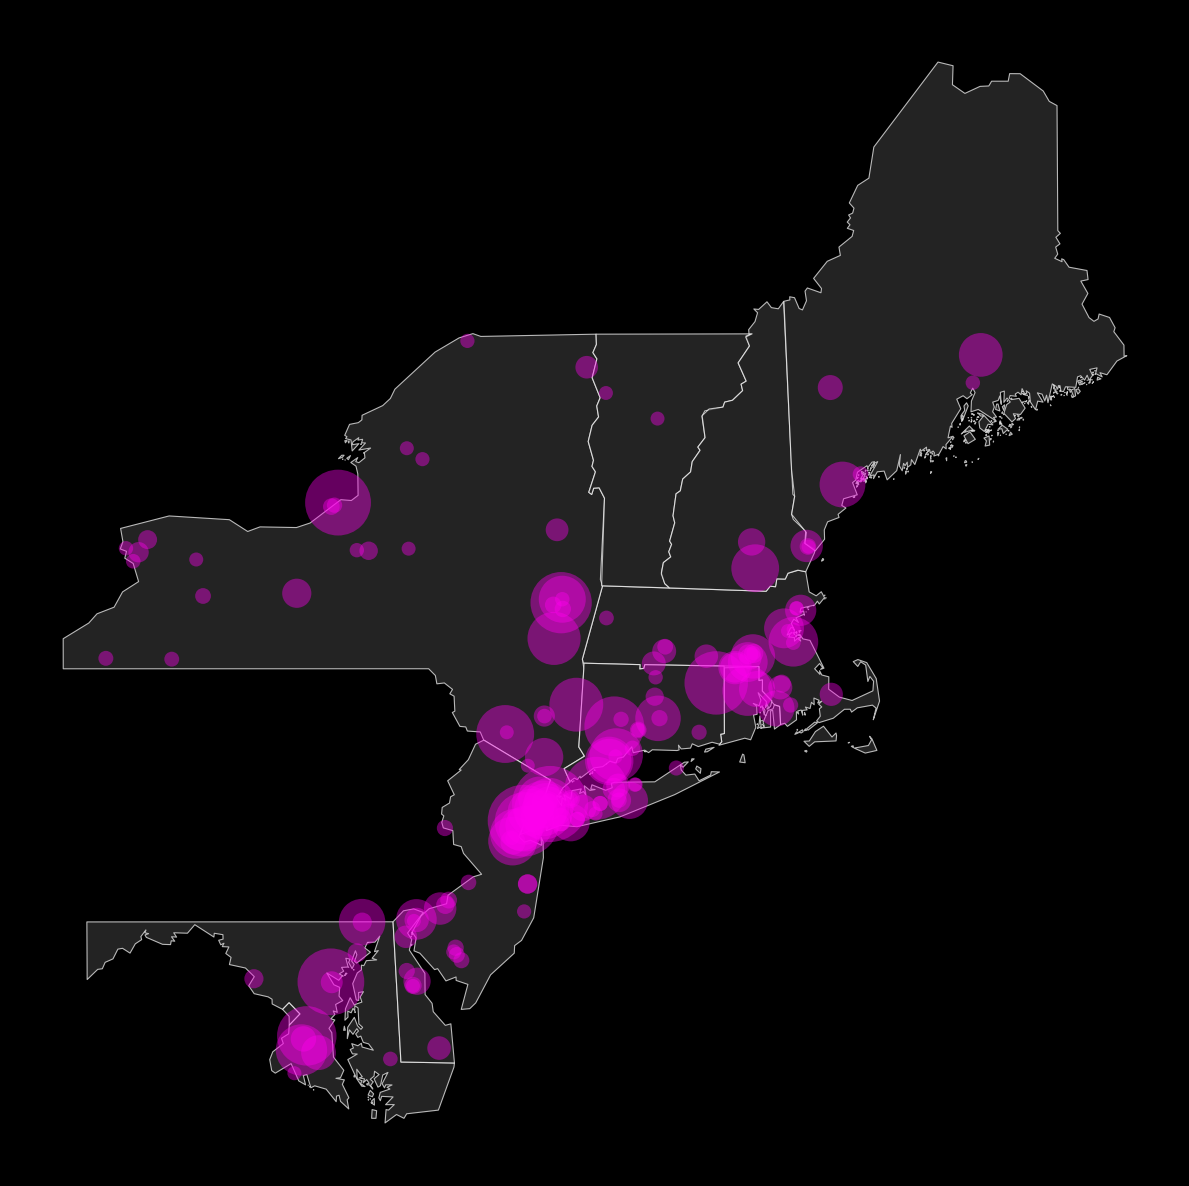

In [45]:
usa  = geopandas.read_file(RAW_DATA_DIR / "cb_2018_us_state_500k")
usa.geometry = usa.simplify(tolerance = 0.02)

pps = geo_pps.merge(
    rggi_pps[rggi_pps["Year"] == 2024],
    left_on = "Plant_Code",
    right_on = "ORIS Code",
    how = "right",
    indicator = True
    )
# There are seven unmerged power plants. They were decomissioned in 2024.
#pps["_merge"].value_counts()
#unmerged = pps[pps["_merge"] == "right_only"]
pps = pps[pps["_merge"] == "both"].drop("_merge", axis = 1)

# Create the map with visible country boundaries
fig, ax = plt.subplots(figsize=(12, 12))
# Match the background color to the expected landing page's color
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# Plot Northeastern USA
states_ne = [
 "Connecticut",
 "Delaware",
 "District of Columbia",
 "Maine",
 "Maryland",
 "Massachusetts",
 "New Hampshire",
 "New Jersey",
 "New York",
 #"Pennsylvania",
 "Rhode Island",
 "Vermont",
 #"Virginia",
 #"West Virginia"
 ]
usa[usa["NAME"].isin(states_ne)].plot(
    ax=ax, color=(0.2, 0.2, 0.2), alpha=0.7, edgecolor='white', linewidth=0.8
    )

# Scale marker sizes based on CO2 Mass (tons)
# Normalize CO2 mass to a reasonable marker size range (10-300)
min_size, max_size = 100, 3000
co2_mass = pps["CO2 Mass (Tons)"]
scaled_sizes = (
    min_size
    + (max_size-min_size) * (co2_mass-co2_mass.min())
    / (co2_mass.max() - co2_mass.min())
)

# Plot power plants with scaled sizes
pps.plot(
    ax=ax, color=(255/255, 0/255, 238/255), markersize=scaled_sizes,
    alpha=0.4, edgecolor = "none"
    )

# Remove axes
ax.axis('off')

# Zoom in on the right (eastern) side of the map
#ax.set_xlim(-82, -67)
#ax.set_ylim(38, 48)

plt.tight_layout()
plt.savefig("tmp.svg", format='svg', bbox_inches='tight')